In [14]:
# Enhanced Eyewear Recommendation System with Camera & Popularity-Based Recommendation
# Author: Frans Sebastian

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Start webcam and capture face
def capture_face_from_camera():
    cap = cv2.VideoCapture(0)
    print("[INFO] Press 'c' to capture a photo or 'q' to quit.")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        cv2.imshow('Camera - Press c to capture', frame)

        key = cv2.waitKey(1)
        if key & 0xFF == ord('c'):
            img_path = 'captured_face.jpg'
            cv2.imwrite(img_path, frame)
            print(f"[INFO] Image saved to {img_path}")
            cap.release()
            cv2.destroyAllWindows()
            return img_path
        elif key & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return None

# Extract landmarks
def extract_face_landmarks(image_path):
    image = cv2.imread(image_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb)
    h, w = image.shape[:2]
    if result.multi_face_landmarks:
        for face in result.multi_face_landmarks:
            landmarks = [(int(p.x * w), int(p.y * h)) for p in face.landmark]
            return landmarks
    return None

# Compute geometric facial features
def compute_geometric_features(landmarks):
    jaw_width = np.linalg.norm(np.array(landmarks[234]) - np.array(landmarks[454]))
    face_height = np.linalg.norm(np.array(landmarks[10]) - np.array(landmarks[152]))
    eye_distance = np.linalg.norm(np.array(landmarks[133]) - np.array(landmarks[362]))
    chin_width = np.linalg.norm(np.array(landmarks[58]) - np.array(landmarks[288]))
    ratio_jaw_to_height = jaw_width / face_height
    ratio_eye_to_height = eye_distance / face_height
    return {
        "jaw_width": jaw_width,
        "face_height": face_height,
        "eye_distance": eye_distance,
        "chin_width": chin_width,
        "ratio_jaw_to_height": ratio_jaw_to_height,
        "ratio_eye_to_height": ratio_eye_to_height
    }

# Simulated product catalog with popularity
products = pd.DataFrame({
    "product_id": list(range(1, 21)),
    "brand": ["RayBan", "Gucci", "Local", "Oakley", "Levi's", "Prada", "Persol", "Chanel", "Giorgio Armani", "Zara",
               "H&M", "Dior", "Tom Ford", "Nike", "Adidas", "Fendi", "Burberry", "Guess", "Lacoste", "Versace"],
    "style": ["classic", "trendy", "minimal", "sporty", "classic", "trendy", "classic", "fashion", "elegant", "urban",
               "urban", "luxury", "premium", "active", "sporty", "fashion", "trendy", "minimal", "cool", "bold"],
    "popularity": [87, 93, 74, 88, 84, 90, 80, 77, 85, 79,
                   75, 91, 86, 89, 83, 78, 82, 73, 81, 88],
    "social_mentions": [200, 500, 120, 160, 180, 350, 220, 190, 250, 170,
                        160, 400, 230, 300, 260, 210, 240, 140, 205, 275],
    "material": ["plastic"] * 10 + ["metal"] * 10,
    "price": [1000000, 1200000, 750000, 950000, 1100000, 1250000, 980000, 1300000, 1150000, 1020000,
              1010000, 1400000, 1350000, 1230000, 1120000, 1190000, 1180000, 870000, 1080000, 1380000],
    "weight_g": [24, 22, 27, 25, 26, 23, 24, 22, 28, 26,
                 23, 25, 21, 22, 24, 23, 27, 26, 25, 22],
    "lens_antirad": [True, True, False, True, True, False, True, False, True, True,
                      False, True, False, True, False, True, False, True, False, True]
})

# Trend score calculation
def compute_trend_score(df):
    trend_features = df[["popularity", "social_mentions"]]
    scaler = StandardScaler()
    normed = scaler.fit_transform(trend_features)
    df["trend_score"] = PCA(n_components=1).fit_transform(normed)
    return df

products = compute_trend_score(products)

# Recommend top N products based on all preferences
def recommend_products(products_df, preferences, top_n=5):
    filtered = products_df[
        (products_df["style"] == preferences["style"]) &
        (products_df["material"] == preferences["material"]) &
        (products_df["price"] <= preferences["budget"]) &
        (products_df["weight_g"] <= preferences["max_weight"]) &
        (products_df["lens_antirad"] == preferences["lens_antirad"])
    ]
    top_recommendations = filtered.sort_values(by="trend_score", ascending=False).head(top_n)
    return top_recommendations[["product_id", "brand", "style", "trend_score", "price", "weight_g"]]

# Execution
if __name__ == "__main__":
    default_image_path = "captured_face.jpg"
    image_path = default_image_path if os.path.exists(default_image_path) else capture_face_from_camera()

    if not image_path:
        print("[INFO] No image captured.")
        exit()

    landmarks = extract_face_landmarks(image_path)
    if not landmarks:
        print("[ERROR] No face detected.")
        exit()

    features = compute_geometric_features(landmarks)
    print("\n[RESULT] Facial Features:")
    for k, v in features.items():
        print(f"{k}: {v:.2f}")

    user_preferences = {
        "style": "trendy",
        "material": "plastic",
        "budget": 1300000,
        "max_weight": 25,
        "lens_antirad": True
    }

    print(f"\n[RECOMMENDATION] Top products for user preferences:")
    recommendations = recommend_products(products, user_preferences)
    print(recommendations.to_string(index=False))


I0000 00:00:1750504269.590389  343529 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1750504269.595263  347884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750504269.600052  347884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[INFO] Press 'c' to capture a photo or 'q' to quit.
[INFO] Image saved to captured_face.jpg

[RESULT] Facial Features:
jaw_width: 491.10
face_height: 618.03
eye_distance: 128.02
chin_width: 442.11
ratio_jaw_to_height: 0.79
ratio_eye_to_height: 0.21

[RECOMMENDATION] Top products for user preferences:
 product_id brand  style  trend_score   price  weight_g
          2 Gucci trendy     3.260625 1200000        22


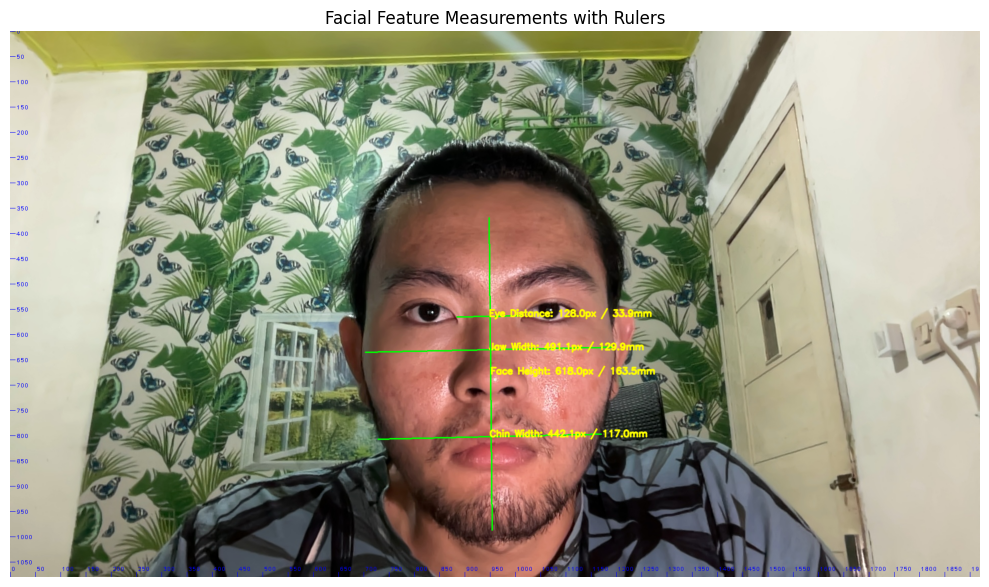

In [15]:
# Overlay face metrics directly on the face image with annotations and visual rulers
import cv2
import matplotlib.pyplot as plt
import numpy as np


def annotate_face_metrics(image_path, landmarks, features, px_per_mm=3.78):
    image = cv2.imread(image_path)
    annotated = image.copy()

    # Define points for metric annotations
    points = {
        "Jaw Width": (landmarks[234], landmarks[454]),
        "Face Height": (landmarks[10], landmarks[152]),
        "Eye Distance": (landmarks[133], landmarks[362]),
        "Chin Width": (landmarks[58], landmarks[288])
    }

    # Draw measurement lines and labels
    for name, (pt1, pt2) in points.items():
        cv2.line(annotated, pt1, pt2, (0, 255, 0), 2)
        mid_point = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
        px_value = features[name.lower().replace(" ", "_")]
        mm_value = px_value / px_per_mm
        label = f"{name}: {px_value:.1f}px / {mm_value:.1f}mm"
        cv2.putText(annotated, label, mid_point, cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 255), 2, cv2.LINE_AA)

    # Draw horizontal and vertical pixel rulers
    height, width = annotated.shape[:2]
    for i in range(0, height, 50):
        cv2.line(annotated, (0, i), (10, i), (255, 0, 0), 1)
        cv2.putText(annotated, str(i), (12, i + 5), cv2.FONT_HERSHEY_PLAIN, 0.8, (255, 0, 0), 1)

    for i in range(0, width, 50):
        cv2.line(annotated, (i, height - 1), (i, height - 10), (255, 0, 0), 1)
        cv2.putText(annotated, str(i), (i + 2, height - 12), cv2.FONT_HERSHEY_PLAIN, 0.8, (255, 0, 0), 1)

    # Convert and plot
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.title("Facial Feature Measurements with Rulers")
    plt.tight_layout()
    plt.show()

# Usage in main:
annotate_face_metrics(image_path, landmarks, features)


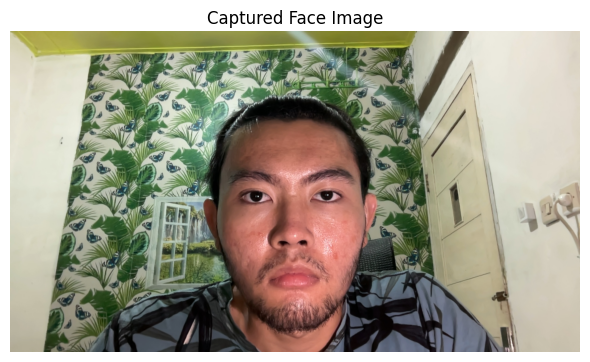

/var/folders/gy/blrgglk56_z7vm1yk7q82rzc0000gr/T/ipykernel_56606/2796886132.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="viridis")


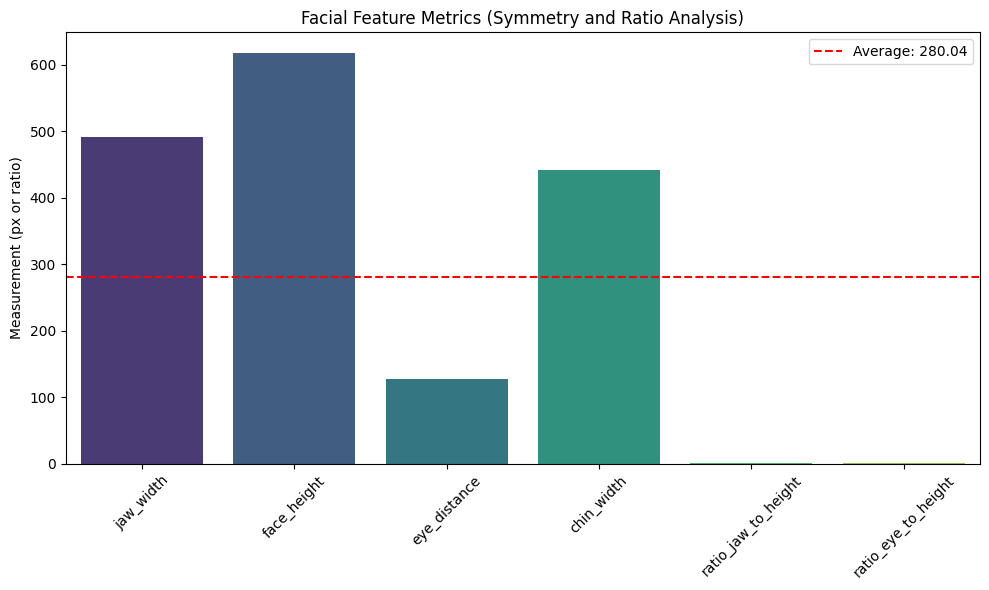

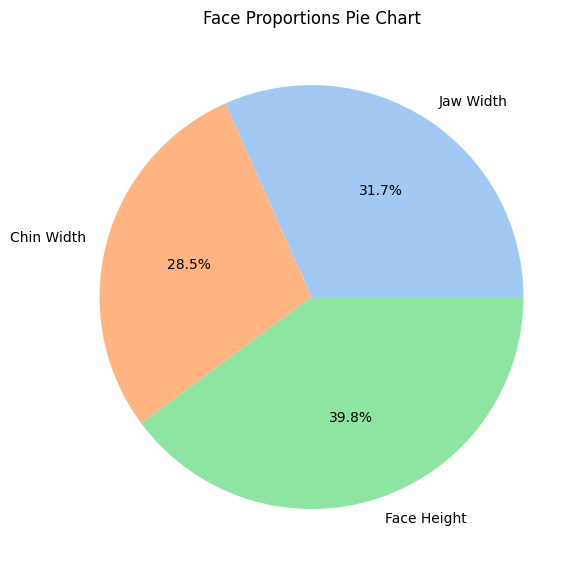

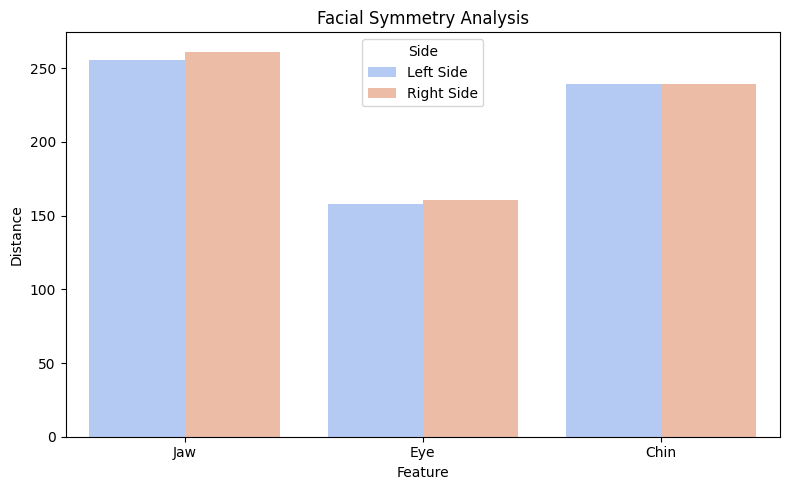

In [16]:
# Add-on: Comprehensive Face Metric Visualizations and Captured Image Display
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Show captured image
def show_captured_face(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Captured Face Image")
    plt.tight_layout()
    plt.show()

# Barplot for all face feature metrics
def plot_face_metrics(features):
    metric_names = list(features.keys())
    metric_values = list(features.values())
    mean_val = np.mean(metric_values)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric_names, y=metric_values, palette="viridis")
    plt.axhline(mean_val, color='red', linestyle='--', label=f'Average: {mean_val:.2f}')
    plt.title("Facial Feature Metrics (Symmetry and Ratio Analysis)")
    plt.ylabel("Measurement (px or ratio)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pie chart for height vs width face proportions
def plot_face_proportion(features):
    face_height = features.get("face_height", 0)
    jaw_width = features.get("jaw_width", 0)
    chin_width = features.get("chin_width", 0)

    labels = ["Jaw Width", "Chin Width", "Face Height"]
    values = [jaw_width, chin_width, face_height]

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    plt.title("Face Proportions Pie Chart")
    plt.tight_layout()
    plt.show()

# Symmetry plot (horizontal features vs left/right)
def plot_symmetry_analysis(landmarks):
    left_indices = [234, 133, 58]
    right_indices = [454, 362, 288]
    feature_names = ["Jaw", "Eye", "Chin"]

    left_vals = [np.linalg.norm(np.array(landmarks[i]) - np.array(landmarks[1])) for i in left_indices]
    right_vals = [np.linalg.norm(np.array(landmarks[i]) - np.array(landmarks[1])) for i in right_indices]

    df_symmetry = pd.DataFrame({"Feature": feature_names, "Left Side": left_vals, "Right Side": right_vals})
    df_symmetry_melted = df_symmetry.melt(id_vars="Feature", var_name="Side", value_name="Distance")

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_symmetry_melted, x="Feature", y="Distance", hue="Side", palette="coolwarm")
    plt.title("Facial Symmetry Analysis")
    plt.tight_layout()
    plt.show()

# Example usage inside __main__ after computing features and landmarks:
show_captured_face(image_path)
plot_face_metrics(features)
plot_face_proportion(features)
plot_symmetry_analysis(landmarks)

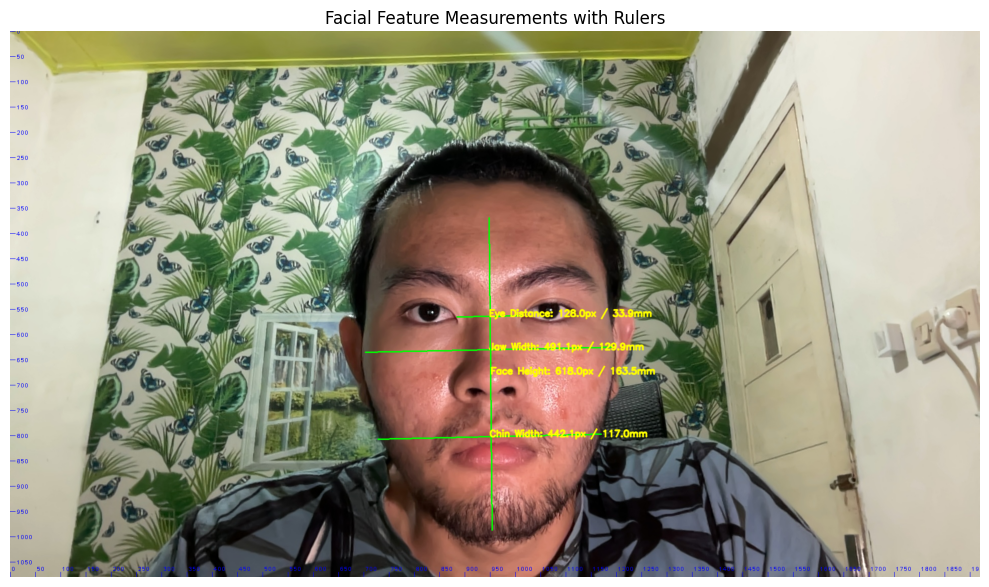

In [17]:
# Overlay face metrics directly on the face image with annotations and visual rulers
import cv2
import matplotlib.pyplot as plt
import numpy as np


def annotate_face_metrics(image_path, landmarks, features, px_per_mm=3.78):
    image = cv2.imread(image_path)
    annotated = image.copy()

    # Define points for metric annotations
    points = {
        "Jaw Width": (landmarks[234], landmarks[454]),
        "Face Height": (landmarks[10], landmarks[152]),
        "Eye Distance": (landmarks[133], landmarks[362]),
        "Chin Width": (landmarks[58], landmarks[288])
    }

    # Draw measurement lines and labels
    for name, (pt1, pt2) in points.items():
        cv2.line(annotated, pt1, pt2, (0, 255, 0), 2)
        mid_point = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
        px_value = features[name.lower().replace(" ", "_")]
        mm_value = px_value / px_per_mm
        label = f"{name}: {px_value:.1f}px / {mm_value:.1f}mm"
        cv2.putText(annotated, label, mid_point, cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 255), 2, cv2.LINE_AA)

    # Draw horizontal and vertical pixel rulers
    height, width = annotated.shape[:2]
    for i in range(0, height, 50):
        cv2.line(annotated, (0, i), (10, i), (255, 0, 0), 1)
        cv2.putText(annotated, str(i), (12, i + 5), cv2.FONT_HERSHEY_PLAIN, 0.8, (255, 0, 0), 1)

    for i in range(0, width, 50):
        cv2.line(annotated, (i, height - 1), (i, height - 10), (255, 0, 0), 1)
        cv2.putText(annotated, str(i), (i + 2, height - 12), cv2.FONT_HERSHEY_PLAIN, 0.8, (255, 0, 0), 1)

    # Convert and plot
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.title("Facial Feature Measurements with Rulers")
    plt.tight_layout()
    plt.show()

# Usage in main:
annotate_face_metrics(image_path, landmarks, features)